In [1]:
import torch
from tqdm import tqdm
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import SimpleITK as sitk
from lazy_imports import itkwidgets
from lazy_imports import itkview
from lazy_imports import interactive
from lazy_imports import ipywidgets
from lazy_imports import pv

In [2]:
from mtch.RegistrationFunc3D import *
from mtch.SplitEbinMetric3D import *
from mtch.GeoPlot import *

In [3]:
# from Packages.disp.vis import show_2d, show_2d_tensors
from disp.vis import vis_tensors, vis_path, disp_scalar_to_file
from disp.vis import disp_vector_to_file, disp_tensor_to_file
from disp.vis import disp_gradG_to_file, disp_gradA_to_file
from disp.vis import view_3d_tensors, tensors_to_mesh

In [4]:
import algo.metricModSolver2d as mms
import algo.geodesic as geo
import algo.euler as euler
import algo.dijkstra as dijkstra

In [5]:
from torch import linalg as la

In [16]:
mode = 'gpu'
if mode=='gpu':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # after switch device, you need restart the script
    torch.cuda.set_device(0)
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
else:
    device = torch.device('cpu')
    torch.set_default_dtype(torch.float64)

In [7]:
def compute_eigenvalues(input: torch.Tensor):
    h, w, d, _, _ = input.size()
    a11 = input[:, :, :, 0, 0].double()
    a12 = input[:, :, :, 0, 1].double()
    a13 = input[:, :, :, 0, 2].double()
    a22 = input[:, :, :, 1, 1].double()
    a23 = input[:, :, :, 1, 2].double()
    a33 = input[:, :, :, 2, 2].double()
    eig_vals = torch.zeros(h, w, d, 3).to(input.device).double()

    nd = torch.pow(a12, 2) + torch.pow(a13, 2) + torch.pow(a23, 2)

    if torch.any(nd != 0):
        q = (a11 + a22 + a33) / 3.0
        p = torch.pow((a11 - q), 2) + torch.pow((a22 - q), 2) + torch.pow((a33 - q), 2) + 2.0 * nd
        p = torch.sqrt(p / 6.0)

        r = torch.pow((1.0 / p), 3) * ((a11 - q) * ((a22 - q) * (a33 - q) - a23 * a23) - a12 * (
                a12 * (a33 - q) - a13 * a23) + a13 * (a12 * a23 - a13 * (a22 - q))) / 2.0

        phi = torch.acos(r) / 3.0
        phi[r <= -1] = pi / 3
        phi[r >= 1] = 0

        eig_vals[:, :, :, 0] = q + 2 * p * torch.cos(phi)
        eig_vals[:, :, :, 2] = q + 2 * p * torch.cos(phi + pi * (2.0 / 3.0))
        eig_vals[:, :, :, 1] = 3 * q - eig_vals[:, :, :, 0] - eig_vals[:, :, :, 2]

    if torch.any(nd == 0):
        diag_matrix_index = torch.where(nd == 0)
        eig_vals[:, :, :, 0][diag_matrix_index] = a11[diag_matrix_index]
        eig_vals[:, :, :, 1][diag_matrix_index] = a22[diag_matrix_index]
        eig_vals[:, :, :, 2][diag_matrix_index] = a33[diag_matrix_index]
    print(eig_vals.type())
    return eig_vals

In [8]:
length = 200
tensor_rand = torch.rand(6,length,length,length)

In [9]:
tensor_symmetric = torch.zeros((3,3,length,length,length))
tensor_symmetric[0,0] = tensor_rand[0]
tensor_symmetric[0,1] = tensor_rand[1]
tensor_symmetric[0,2] = tensor_rand[2]
tensor_symmetric[1,0] = tensor_rand[1]
tensor_symmetric[1,1] = tensor_rand[3]
tensor_symmetric[1,2] = tensor_rand[4]
tensor_symmetric[2,0] = tensor_rand[2]
tensor_symmetric[2,1] = tensor_rand[4]
tensor_symmetric[2,2] = tensor_rand[5]
tensor_psd = torch.matrix_exp(tensor_symmetric.permute(2,3,4,0,1))

In [10]:
import time

In [17]:
%%time
a = compute_eigenvalues(tensor_psd.to(device))
torch.sum(a, (-1)).type()

torch.cuda.DoubleTensor
CPU times: user 3.41 s, sys: 789 ms, total: 4.2 s
Wall time: 4.45 s


'torch.cuda.DoubleTensor'

In [18]:
%%time
b = torch.linalg.eigvals(tensor_psd.to(device)).real
torch.sum(b, (-1)).type()

CPU times: user 17.5 s, sys: 436 ms, total: 18 s
Wall time: 14.9 s


'torch.cuda.DoubleTensor'

In [ ]:
%%time
c = torch.symeig(tensor_psd.to(device), eigenvectors=True)[0]
torch.sum(c, (-1)).type()

In [14]:
torch.sum(torch.log(ev_compute) ** 2, (-1))

NameError: name 'ev_compute' is not defined

In [15]:
torch.sum(torch.log(ev_eigvals) ** 2, (-1))

NameError: name 'ev_eigvals' is not defined

In [23]:
torch.sum(torch.log(ev_symeig) ** 2, (-1))

tensor([[[3.7513, 0.3651, 2.5773,  ..., 2.8953, 2.5914, 1.9670],
         [2.2858, 2.4179, 4.2734,  ..., 2.9989, 2.3992, 2.6493],
         [2.6776, 1.9859, 2.8950,  ..., 2.3942, 5.4251, 3.3042],
         ...,
         [2.0228, 2.3759, 3.0897,  ..., 4.5562, 3.7919, 4.0769],
         [3.8905, 2.1013, 1.5331,  ..., 0.8359, 2.4469, 1.8388],
         [2.1955, 2.0983, 2.8195,  ..., 6.2514, 2.5539, 1.8819]],

        [[1.9546, 3.0803, 4.1626,  ..., 4.1607, 1.3837, 3.3956],
         [2.9694, 4.3767, 3.7231,  ..., 3.3218, 2.1218, 5.7248],
         [4.7651, 4.8011, 2.5437,  ..., 4.0145, 3.8681, 3.9207],
         ...,
         [2.3323, 4.2464, 3.1693,  ..., 4.4671, 3.4908, 3.8269],
         [3.8638, 2.9806, 2.5045,  ..., 3.2118, 0.1861, 2.6195],
         [3.3888, 3.1386, 1.9089,  ..., 1.9357, 5.4593, 1.9556]],

        [[2.6642, 2.7570, 3.5018,  ..., 4.1753, 1.3042, 2.1998],
         [3.2421, 1.9905, 3.3665,  ..., 2.8691, 1.8344, 3.0069],
         [2.2511, 2.7952, 4.5326,  ..., 3.2880, 4.5484, 1.

In [37]:
torch.sum(torch.log(b) ** 2, (-1))-torch.sum(torch.log(c) ** 2, (-1))

tensor([[[-3.5527e-15,  1.2768e-15,  0.0000e+00,  ..., -6.2172e-15,
           5.3291e-15, -4.4409e-16],
         [ 4.4409e-16,  1.3323e-15,  3.5527e-15,  ..., -4.4409e-16,
           4.4409e-16,  1.7764e-15],
         [ 3.1086e-15, -4.4409e-16,  8.8818e-16,  ..., -3.1086e-15,
          -8.8818e-16, -4.4409e-15],
         ...,
         [ 0.0000e+00, -1.7764e-15, -1.7764e-15,  ...,  2.6645e-15,
           4.8850e-15, -2.6645e-15],
         [ 3.5527e-15, -4.4409e-16, -8.8818e-16,  ...,  1.1102e-16,
           8.8818e-16,  1.5543e-15],
         [ 2.2204e-15, -8.8818e-16, -2.2204e-15,  ...,  1.7764e-15,
          -1.7764e-15,  2.2204e-16]],

        [[-6.6613e-16,  2.2204e-15,  3.5527e-15,  ...,  8.8818e-16,
          -2.4425e-15,  4.8850e-15],
         [-2.2204e-15,  2.6645e-15, -7.1054e-15,  ...,  2.2204e-15,
          -4.4409e-16, -3.5527e-15],
         [-1.7764e-15, -2.6645e-15,  4.4409e-16,  ..., -8.8818e-16,
           8.8818e-16,  3.5527e-15],
         ...,
         [ 8.8818e-16,  3

In [22]:
torch.sum(ev_cos, (-1))-torch.sum(ev_torch, (-1))

tensor([[[-2.3842e-07, -1.1921e-06, -1.4305e-06,  ..., -2.3842e-07,
          -9.5367e-07,  2.3842e-07],
         [ 5.9605e-07, -4.7684e-07, -7.1526e-07,  ..., -3.5763e-07,
           1.1921e-06,  1.7881e-06],
         [ 2.3842e-06,  2.3842e-07, -2.3842e-07,  ...,  1.1921e-06,
          -2.3842e-07, -7.1526e-07],
         ...,
         [-1.1921e-06,  3.5763e-07,  7.1526e-07,  ..., -3.5763e-07,
           3.5763e-07, -1.9073e-06],
         [ 5.9605e-07, -2.3842e-07, -2.3842e-07,  ...,  1.1921e-07,
          -1.1921e-07, -8.3447e-07],
         [-2.3842e-07, -4.7684e-07, -1.1921e-07,  ...,  1.0729e-06,
          -1.1921e-07, -2.3842e-07]],

        [[ 9.5367e-07,  2.3842e-07, -1.1921e-07,  ...,  4.7684e-07,
          -9.5367e-07,  9.5367e-07],
         [ 1.1921e-06, -1.1921e-07,  2.3842e-07,  ...,  0.0000e+00,
           1.9073e-06, -3.5763e-07],
         [ 1.4305e-06,  0.0000e+00,  0.0000e+00,  ..., -3.5763e-07,
           1.0729e-06,  7.1526e-07],
         ...,
         [-1.1921e-07, -1

In [10]:
diffeo = sio.loadmat(f'/home/sci/hdai/Projects/Atlas3D/Brain2AtlasMay21/103818_799_energy.mat')['energy']

In [11]:
diffeo.shape

(1, 800)

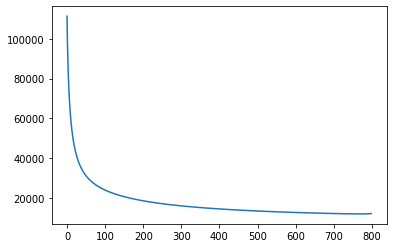

In [12]:
plt.plot(diffeo[0])

In [5]:
path = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
s = 1
tensor_np = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic{s}_orig_tensors.nhdr')),(3,2,1,0))
print(tensor_np.shape)
# mask_np = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic{s}_filt_mask.nhdr')),(2,1,0))
np.mean(tensor_np[:,:,:,21]-tensor_np[:,:,:,19])

(6, 100, 100, 41)


0.0008008409777276603

In [6]:
path = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
s = 1
tensor_np = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic{s}_orig_tensors.nhdr')),(3,2,1,0))
# mask_np = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic{s}_filt_mask.nhdr')),(2,1,0))
np.mean(tensor_np[:,:,:,22]-tensor_np[:,:,:,18])

0.006613043901924739

In [7]:
path = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
s = 1
tensor_np = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic{s}_orig_tensors.nhdr')),(3,2,1,0))
# mask_np = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic{s}_filt_mask.nhdr')),(2,1,0))
np.mean(tensor_np[:,:,:,23]-tensor_np[:,:,:,17])

0.013798560802689663

In [8]:
path = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
s = 2
tensor_np = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic{s}_orig_tensors.nhdr')),(3,2,1,0))
# mask_np = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic{s}_filt_mask.nhdr')),(2,1,0))
np.mean(tensor_np[:,:,:,21]-tensor_np[:,:,:,19])

0.0015515587368096222

In [9]:
path = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
s = 4
tensor_np = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic{s}_orig_tensors.nhdr')),(3,2,1,0))
# mask_np = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic{s}_filt_mask.nhdr')),(2,1,0))
np.mean(tensor_np[:,:,:,21]-tensor_np[:,:,:,19])

0.0009034099626365979

In [10]:
path = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
s = 6
tensor_np = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic{s}_orig_tensors.nhdr')),(3,2,1,0))
# mask_np = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{path}/cubic{s}_filt_mask.nhdr')),(2,1,0))
np.mean(tensor_np[:,:,:,21]-tensor_np[:,:,:,19])

0.0014410623116006644

In [11]:
tensor_np.shape

(6, 100, 100, 41)

In [12]:
# start_coords = [[17, 22, 21]]
# start_coords = [[50, 51, 21]]
# start_coords = [[83, 71, 21]]
start_coords = [[13, 14, 21]]
init_velocities = [None]
# tens_4_path = atlas_lin

geo_delta_t = 0.1#0.01#0.005
geo_iters = 1200 # 22000 for Kris annulus(delta_t=0.005), 32000 for cubic (delta_t=0.005)
euler_delta_t = 0.01
euler_iters = 8000 # 14600

# geodesicpath_3d([6,h,w,d],[h,w,d],...)
geox, geoy, geoz = geo.geodesicpath_3d(tensor_np, mask_np,\
                              start_coords[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters, both_directions=True)
#scalegeox, scalegeoy = geo.geodesicpath(scaled_tens_4_path, filt_mask,\
#                              start_coords[0], init_velocities[0], \
#                              geo_delta_t, iter_num=geo_iters)

# eulerpath_3d([6,h,w,d],[h,w,d],...)
# eulx, euly, eulz = euler.eulerpath_3d(tensor_np, mask_np,\
#                               start_coords[0], init_velocities[0], euler_delta_t, iter_num=euler_iters, both_directions=True)

NameError: name 'mask_np' is not defined

In [13]:
# geospline=pv.Spline(np.column_stack((geoz, geoy, geox)), 500)
# geotube = geospline.tube(radius=0.5)
# eulspline=pv.Spline(np.column_stack((eulz, euly, eulx)), 500)
# eultube = eulspline.tube(radius=0.5)
# view_3d_tensors([h,w,d,6],[h,w,d],...)
vwr=view_3d_tensors(np.transpose(tensor_np,(1,2,3,0)),mask_np,mask_np,paths=[(geox[:geo_iters-1],geoy[:geo_iters-1],geoz[:geo_iters-1])],stride=7,scale=6)
# vwr=view_3d_tensors(np.transpose(tensor_np,(1,2,3,0)),mask_np,mask_np,paths=[(eulx,euly,eulz)],stride=7,scale=6)
vwr

NameError: name 'mask_np' is not defined

In [14]:
geox.shape

NameError: name 'geox' is not defined

In [10]:
def view_3d_diffeos(diffeo, stride, interp):
    height, width, depth = diffeo.shape[1:]
    spline = []
    for i in range(1,height,stride):
        for j in range(1,width,stride):
            spline.append(pv.Spline(np.transpose(diffeo[:,i,j,:]), interp))
            
#     for i in range(1,height,stride):
#         for k in range(1,depth,stride):
#             spline.append(pv.Spline(np.transpose(diffeo[:,i,:,k]), interp))
            
#     for j in range(1,width,stride):
#         for k in range(1,depth,stride):
#             spline.append(pv.Spline(np.transpose(diffeo[:,:,j,k]), interp))
            
    return itkview(geometries=spline)

In [15]:
output_dir = 'Cubic1246AtlasNoDeviation2e-3'
diffeo = sio.loadmat(f'{output_dir}/cubic1_100_phi_inv.mat')['diffeo']
vwr = view_3d_diffeos(diffeo, 10,1000)
vwr

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [16]:
output_dir = 'Cubic1246Atlas'
diffeo = sio.loadmat(f'{output_dir}/cubic1_100_phi_inv.mat')['diffeo']
vwr = view_3d_diffeos(diffeo, 10,1000)
vwr

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [37]:
input_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
output_dir = 'Cubic1246AtlasNoDeviation'
atlas_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/atlas_400_tens.nhdr')),(3,2,1,0))
mask_acc = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/cubic5_filt_mask.nhdr')),(2,1,0))
path_set = []
# start_coords = [[17, 22, 21]]
# start_coords = [[50, 51, 21]]
# start_coords = [[83, 71, 21]] 
start_coords = [[13, 14, 21]] # golden test start point
init_velocities = [None]

geo_delta_t = -0.1
geo_iters = 500 
euler_delta_t = 0.1
euler_iters = 8000 

# geodesicpath_3d([6,h,w,d],[h,w,d],...)
geox, geoy, geoz = geo.geodesicpath_3d(atlas_lin, mask_acc,\
                              start_coords[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters, both_directions=False)

# eulerpath_3d([6,h,w,d],[h,w,d],...)
# eulx, euly, eulz = euler.eulerpath_3d(atlas_lin, mask_acc,\
#                               start_coords[0], init_velocities[0], euler_delta_t, iter_num=euler_iters, both_directions=False)
path_set = [(geox[:-1], geoy[:-1], geoz[:-1])]

# view_3d_tensors([h,w,d,6],[h,w,d],...)
vwr=view_3d_tensors(np.transpose(atlas_lin,(1,2,3,0)),mask_acc,atlas_lin[3,:,:,:],paths=path_set,stride=6,scale=6)
vwr

Finding geodesic path from [13, 14, 21] with initial velocity [-2.78320707e-01 -9.60488152e-01  3.06480418e-04]
numpts 86
smallest,largest max eigenvalue 0.3127716010427184 8.285921962550137


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [30]:
input_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
output_dir = 'Cubic1246AtlasNoDeviation'
atlas_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/atlas_300_tens.nhdr')),(3,2,1,0))
mask_acc = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/cubic5_filt_mask.nhdr')),(2,1,0))
path_set = []
# start_coords = [[17, 22, 21]]
# start_coords = [[50, 51, 21]]
# start_coords = [[83, 71, 21]] 
start_coords = [[13, 14, 21]] # golden test start point
init_velocities = [None]

geo_delta_t = -0.1
geo_iters = 500 
euler_delta_t = 0.1
euler_iters = 8000 

# geodesicpath_3d([6,h,w,d],[h,w,d],...)
geox, geoy, geoz = geo.geodesicpath_3d(atlas_lin, mask_acc,\
                              start_coords[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters, both_directions=False)

# eulerpath_3d([6,h,w,d],[h,w,d],...)
# eulx, euly, eulz = euler.eulerpath_3d(atlas_lin, mask_acc,\
#                               start_coords[0], init_velocities[0], euler_delta_t, iter_num=euler_iters, both_directions=False)
path_set = [(geox[:-1], geoy[:-1], geoz[:-1])]

# view_3d_tensors([h,w,d,6],[h,w,d],...)
vwr=view_3d_tensors(np.transpose(atlas_lin,(1,2,3,0)),mask_acc,atlas_lin[3,:,:,:],paths=path_set,stride=6,scale=6)
vwr

Finding geodesic path from [13, 14, 21] with initial velocity [-2.81913076e-01 -9.59439950e-01  1.73268427e-05]
numpts 86
smallest,largest max eigenvalue 0.31286437684354523 8.30988022110784


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [35]:
input_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
output_dir = 'Cubic1246AtlasNoDeviation'
atlas_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/atlas_200_tens.nhdr')),(3,2,1,0))
mask_acc = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/cubic5_filt_mask.nhdr')),(2,1,0))
path_set = []
# start_coords = [[17, 22, 21]]
# start_coords = [[50, 51, 21]]
# start_coords = [[83, 71, 21]] 
start_coords = [[13, 14, 21]] # golden test start point
init_velocities = [None]

geo_delta_t = -0.1
geo_iters = 500 
euler_delta_t = 0.1
euler_iters = 8000 

# geodesicpath_3d([6,h,w,d],[h,w,d],...)
geox, geoy, geoz = geo.geodesicpath_3d(atlas_lin, mask_acc,\
                              start_coords[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters, both_directions=False)

# eulerpath_3d([6,h,w,d],[h,w,d],...)
# eulx, euly, eulz = euler.eulerpath_3d(atlas_lin, mask_acc,\
#                               start_coords[0], init_velocities[0], euler_delta_t, iter_num=euler_iters, both_directions=False)
path_set = [(geox[:-1], geoy[:-1], geoz[:-1])]

# view_3d_tensors([h,w,d,6],[h,w,d],...)
vwr=view_3d_tensors(np.transpose(atlas_lin,(1,2,3,0)),mask_acc,atlas_lin[3,:,:,:],paths=path_set,stride=6,scale=6)
vwr

Finding geodesic path from [13, 14, 21] with initial velocity [-2.89026321e-01 -9.57321010e-01 -5.19338630e-04]
numpts 86
smallest,largest max eigenvalue 0.3131327619843758 8.32288541203232


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [36]:
input_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
output_dir = 'Cubic1246AtlasNoDeviation'
atlas_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/atlas_100_tens.nhdr')),(3,2,1,0))
mask_acc = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/cubic5_filt_mask.nhdr')),(2,1,0))
path_set = []
# start_coords = [[17, 22, 21]]
# start_coords = [[50, 51, 21]]
# start_coords = [[83, 71, 21]] 
start_coords = [[13, 14, 21]] # golden test start point
init_velocities = [None]

geo_delta_t = -0.1
geo_iters = 500 
euler_delta_t = 0.1
euler_iters = 8000 

# geodesicpath_3d([6,h,w,d],[h,w,d],...)
geox, geoy, geoz = geo.geodesicpath_3d(atlas_lin, mask_acc,\
                              start_coords[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters, both_directions=False)

# eulerpath_3d([6,h,w,d],[h,w,d],...)
# eulx, euly, eulz = euler.eulerpath_3d(atlas_lin, mask_acc,\
#                               start_coords[0], init_velocities[0], euler_delta_t, iter_num=euler_iters, both_directions=False)
path_set = [(geox[:-1], geoy[:-1], geoz[:-1])]

# view_3d_tensors([h,w,d,6],[h,w,d],...)
vwr=view_3d_tensors(np.transpose(atlas_lin,(1,2,3,0)),mask_acc,atlas_lin[3,:,:,:],paths=path_set,stride=6,scale=6)
vwr

Finding geodesic path from [13, 14, 21] with initial velocity [-0.30205263 -0.9532901  -0.00147941]
numpts 86
smallest,largest max eigenvalue 0.31123498296414787 8.32167831653566


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [8]:
input_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
output_dir = 'Cubic1246AtlasNoDeviation2e-3'
atlas_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/atlas_100_tens.nhdr')),(3,2,1,0))
mask_acc = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/cubic5_filt_mask.nhdr')),(2,1,0))
path_set = []
# start_coords = [[17, 22, 21]]
# start_coords = [[50, 51, 21]]
# start_coords = [[83, 71, 21]] 
start_coords = [[13, 14, 21]] # golden test start point
init_velocities = [None]

geo_delta_t = -0.1
geo_iters = 500 
euler_delta_t = 0.1
euler_iters = 8000 

# geodesicpath_3d([6,h,w,d],[h,w,d],...)
geox, geoy, geoz = geo.geodesicpath_3d(atlas_lin, mask_acc,\
                              start_coords[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters, both_directions=False)

# eulerpath_3d([6,h,w,d],[h,w,d],...)
# eulx, euly, eulz = euler.eulerpath_3d(atlas_lin, mask_acc,\
#                               start_coords[0], init_velocities[0], euler_delta_t, iter_num=euler_iters, both_directions=False)
path_set = [(geox[:-1], geoy[:-1], geoz[:-1])]

# view_3d_tensors([h,w,d,6],[h,w,d],...)
vwr=view_3d_tensors(np.transpose(atlas_lin,(1,2,3,0)),mask_acc,atlas_lin[3,:,:,:],paths=path_set,stride=6,scale=6)
vwr

Finding geodesic path from [13, 14, 21] with initial velocity [-2.74761161e-01 -9.61512230e-01  7.32159120e-04]
numpts 86
smallest,largest max eigenvalue 0.3226550052204432 8.253832031595914


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [61]:
import math
def coord_register(point_x, point_y, point_z, diffeo):
  # TODO work out which is y and which is x, maintain consistency.
  # For now, pass in y for point_x, x for point_y
    height, width, depth=diffeo.shape[-3:]
    new_point_x, new_point_y, new_point_z = [], [], []
    for i in range(len(point_x)):
        C = point_x[i] - math.floor(point_x[i])
        D = point_y[i] - math.floor(point_y[i])
        E = point_z[i] - math.floor(point_z[i])
        new_point_x.append(\
          (1.-C)*(1.-D)*(1.-E)*diffeo[0, math.floor(point_x[i])%height, math.floor(point_y[i])%width, math.floor(point_z[i])%depth]\
        + (1.-C)*D*(1.-E)*diffeo[0, math.floor(point_x[i])%height, math.ceil(point_y[i])%width, math.floor(point_z[i])%depth]\
        + C*(1.-D)*(1.-E)*diffeo[0, math.ceil(point_x[i])%height, math.floor(point_y[i])%width, math.floor(point_z[i])%depth]\
        + C*D*(1.-E)*diffeo[0, math.ceil(point_x[i])%height, math.ceil(point_y[i])%width, math.floor(point_z[i])%depth]\
        + (1.-C)*(1.-D)*E*diffeo[0, math.floor(point_x[i])%height, math.floor(point_y[i])%width, math.ceil(point_z[i])%depth]\
        + (1.-C)*D*E*diffeo[0, math.floor(point_x[i])%height, math.ceil(point_y[i])%width, math.ceil(point_z[i])%depth]\
        + C*(1.-D)*E*diffeo[0, math.ceil(point_x[i])%height, math.floor(point_y[i])%width, math.ceil(point_z[i])%depth]\
        + C*D*E*diffeo[0, math.ceil(point_x[i])%height, math.ceil(point_y[i])%width, math.ceil(point_z[i])%depth])

        new_point_y.append(\
          (1.-C)*(1.-D)*(1.-E)*diffeo[1, math.floor(point_x[i])%height, math.floor(point_y[i])%width, math.floor(point_z[i])%depth]\
        + (1.-C)*D*(1.-E)*diffeo[1, math.floor(point_x[i])%height, math.ceil(point_y[i])%width, math.floor(point_z[i])%depth]\
        + C*(1.-D)*(1.-E)*diffeo[1, math.ceil(point_x[i])%height, math.floor(point_y[i])%width, math.floor(point_z[i])%depth]\
        + C*D*(1.-E)*diffeo[1, math.ceil(point_x[i])%height, math.ceil(point_y[i])%width, math.floor(point_z[i])%depth]\
        + (1.-C)*(1.-D)*E*diffeo[1, math.floor(point_x[i])%height, math.floor(point_y[i])%width, math.ceil(point_z[i])%depth]\
        + (1.-C)*D*E*diffeo[1, math.floor(point_x[i])%height, math.ceil(point_y[i])%width, math.ceil(point_z[i])%depth]\
        + C*(1.-D)*E*diffeo[1, math.ceil(point_x[i])%height, math.floor(point_y[i])%width, math.ceil(point_z[i])%depth]\
        + C*D*E*diffeo[1, math.ceil(point_x[i])%height, math.ceil(point_y[i])%width, math.ceil(point_z[i])%depth])

        new_point_z.append(\
          (1.-C)*(1.-D)*(1.-E)*diffeo[2, math.floor(point_x[i])%height, math.floor(point_y[i])%width, math.floor(point_z[i])%depth]\
        + (1.-C)*D*(1.-E)*diffeo[2, math.floor(point_x[i])%height, math.ceil(point_y[i])%width, math.floor(point_z[i])%depth]\
        + C*(1.-D)*(1.-E)*diffeo[2, math.ceil(point_x[i])%height, math.floor(point_y[i])%width, math.floor(point_z[i])%depth]\
        + C*D*(1.-E)*diffeo[2, math.ceil(point_x[i])%height, math.ceil(point_y[i])%width, math.floor(point_z[i])%depth]\
        + (1.-C)*(1.-D)*E*diffeo[2, math.floor(point_x[i])%height, math.floor(point_y[i])%width, math.ceil(point_z[i])%depth]\
        + (1.-C)*D*E*diffeo[2, math.floor(point_x[i])%height, math.ceil(point_y[i])%width, math.ceil(point_z[i])%depth]\
        + C*(1.-D)*E*diffeo[2, math.ceil(point_x[i])%height, math.floor(point_y[i])%width, math.ceil(point_z[i])%depth]\
        + C*D*E*diffeo[2, math.ceil(point_x[i])%height, math.ceil(point_y[i])%width, math.ceil(point_z[i])%depth])
 
    return (new_point_x, new_point_y, new_point_z)

In [83]:
input_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
output_dir = 'Cubic1246Atlas'
atlas_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/atlas_400_tens.nhdr')),(3,2,1,0))
mask_acc = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/cubic5_filt_mask.nhdr')),(2,1,0))
path_set = []
start_coords = [[13, 14, 21]] # golden test start point
init_velocities = [None]

geo_delta_t = -0.1
geo_iters = 500 
euler_delta_t = 0.1
euler_iters = 8000 

# geodesicpath_3d([6,h,w,d],[h,w,d],...)
geox, geoy, geoz = geo.geodesicpath_3d(atlas_lin, mask_acc,\
                              start_coords[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters, both_directions=False)

# eulerpath_3d([6,h,w,d],[h,w,d],...)
# eulx, euly, eulz = euler.eulerpath_3d(atlas_lin, mask_acc,\
#                               start_coords[0], init_velocities[0], euler_delta_t, iter_num=euler_iters, both_directions=False)
path_set = [(geox[:-1], geoy[:-1], geoz[:-1])]

Finding geodesic path from [13, 14, 21] with initial velocity [-0.26389484 -0.96454827  0.00247913]


In [84]:
input_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
output_dir = 'Cubic1246Atlas'
s = 1
tensor_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/cubic{s}_scaled_tensors.nhdr')),(3,2,1,0))
mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/cubic{s}_filt_mask.nhdr')),(2,1,0))
diffeo = sio.loadmat(f'{output_dir}/cubic1_400_phi.mat')['diffeo']
geox, geoy, geoz = geo.geodesicpath_3d(tensor_lin, mask,\
                                        start_coords[0], init_velocities[0], \
                                        -geo_delta_t, iter_num=1300, both_directions=False)
path_set.append((geox[:-1],geoy[:-1],geoz[:-1]))
path_set.append(coord_register(geox[:-1], geoy[:-1], geoz[:-1], diffeo))

Finding geodesic path from [13, 14, 21] with initial velocity [0.32239139 0.94660646 0.        ]


In [85]:
# view_3d_tensors([h,w,d,6],[h,w,d],...)
vwr=view_3d_tensors(np.transpose(atlas_lin,(1,2,3,0)),mask_acc,atlas_lin[3,:,:,:],paths=path_set,stride=6,scale=6)
vwr

numpts 86
smallest,largest max eigenvalue 0.33592650431057974 7.752198883302791


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# brain

In [ ]:
%matplotlib widget
# plt.imshow(fa_list[0][:,:,110])
plt.hist(fa_list[1].flatten().numpy())

In [ ]:
def tensor_cleaning(g, scale_factor):
#     det_zero_map = torch.where(torch.det(g)<=0,1.,0.)
#     background = torch.einsum("mno,ij->mnoij", torch.ones(*tensor_met_zeros.shape[:3]), torch.eye(3))*scale_factor
#     g = g + torch.einsum('ijk...,lijk->ijk...', background, det_zero_map.unsqueeze(0))
    e,_ = torch.symeig(g)
    lambd1_neg_map = torch.where(e[:,:,:,0]<=0,1.,0.)
    lambd2_neg_map = torch.where(e[:,:,:,1]<=0,1.,0.)
    lambd3_neg_map = torch.where(e[:,:,:,2]<=0,1.,0.)
    abnormal_map = torch.where(lambd1_neg_map+lambd2_neg_map+lambd3_neg_map>0,1.,0.)
    background = torch.einsum("mno,ij->mnoij", torch.ones(*tensor_met_zeros.shape[:3]), torch.eye(3))*scale_factor
    return torch.einsum('ijk...,lijk->ijk...', g, 1.-abnormal_map.unsqueeze(0))+\
            torch.einsum('ijk...,lijk->ijk...', background, abnormal_map.unsqueeze(0))

    
def fractional_anisotropy(g):
    e, _ = torch.symeig(g)
    lambd1 = e[:,:,:,0]
    lambd2 = e[:,:,:,1]
    lambd3 = e[:,:,:,2]
    mean = torch.mean(e,dim=len(e.shape)-1)
    return torch.sqrt(3.*(torch.pow((lambd1-mean),2)+torch.pow((lambd2-mean),2)+torch.pow((lambd3-mean),2)))/\
    torch.sqrt(2.*(torch.pow(lambd1,2)+torch.pow(lambd2,2)+torch.pow(lambd3,2)))

In [ ]:
# e, _ = torch.eig(tensor_met_list[0][84,79,110])
e=e[:,0].unsqueeze(0).unsqueeze(0).unsqueeze(0)
lambd1 = e[:,:,:,0]
lambd2 = e[:,:,:,1]
lambd3 = e[:,:,:,2]
mean = torch.mean(e,dim=len(e.shape)-1)
print(torch.sqrt(3.*(torch.pow((lambd1-mean),2)+torch.pow((lambd2-mean),2)+torch.pow((lambd3-mean),2)))/\
    torch.sqrt(2.*(torch.pow(lambd1,2)+torch.pow(lambd2,2)+torch.pow(lambd3,2))))
# print(e)

In [ ]:
e, _ = torch.eig(torch.tensor([[0,0,0],[0,0,0],[0,0,0]],dtype=torch.float64))
print(e)

In [ ]:
print(fractional_anisotropy(tensor_met_list[0])[17,79,110])
# e

In [ ]:
print((fractional_anisotropy(tensor_met_list[0])[:,:,:]>1).nonzero())

In [ ]:
fa_map = torch.where(fa_list[0]>=1,1,0)
itkview(fa_map)

In [ ]:
input_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
output_dir = 'BrainAtlas'
file_name = 111312
tensor_np = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/{file_name}_scaled_tensors.nhdr'))).double().permute(3,2,1,0)
mask_np = sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/{file_name}_filt_mask.nhdr'))

tensor_met_zeros = torch.zeros(*tensor_np.shape[1:],3,3,dtype=torch.float64)
tensor_met_zeros[:,:,:,0,0] = tensor_np[0]
tensor_met_zeros[:,:,:,0,1] = tensor_np[1]
tensor_met_zeros[:,:,:,0,2] = tensor_np[2]
tensor_met_zeros[:,:,:,1,0] = tensor_np[1]
tensor_met_zeros[:,:,:,1,1] = tensor_np[3]
tensor_met_zeros[:,:,:,1,2] = tensor_np[4]
tensor_met_zeros[:,:,:,2,0] = tensor_np[2]
tensor_met_zeros[:,:,:,2,1] = tensor_np[4]
tensor_met_zeros[:,:,:,2,2] = tensor_np[5]
torch.sum(torch.where(torch.det(tensor_met_zeros)<0, 1., 0.))

In [ ]:
sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/{file_name}_scaled_tensors.nhdr')).shape

In [9]:
def view_3d_diffeos(diffeo, stride, interp):
    height, width, depth = diffeo.shape[1:]
    spline = []
    for i in range(1,height,stride):
        for j in range(1,width,stride):
            spline.append(pv.Spline(np.transpose(diffeo[:,i,j,:]), interp))
            
    for i in range(1,height,stride):
        for k in range(1,depth,stride):
            spline.append(pv.Spline(np.transpose(diffeo[:,i,:,k]), interp))
            
#     for j in range(1,width,stride):
#         for k in range(1,depth,stride):
#             spline.append(pv.Spline(np.transpose(diffeo[:,:,j,k]), interp))
            
    return itkview(geometries=spline)

In [10]:
output_dir = 'BrainAtlas'
diffeo = sio.loadmat(f'{output_dir}/105923_25_phi_inv.mat')['diffeo']
vwr = view_3d_diffeos(diffeo, 10,1000)
vwr

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…